In [ ]:
pip install arch


In [ ]:
# importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
import seaborn as sns
from arch import arch_model


In [ ]:
# loading data
data_AAPL = yf.download("AAPL", start = "2022-04-10", end = "2024-04-10")
data_MSFT = yf.download("MSFT", start = "2022-04-10", end = "2024-04-10")

In [ ]:
def rel_return_proc(df):
    returns = [np.NaN]
    for i in range(len(df)-1):
        returns.insert(i+1,(df[i+1]/df[i]-1)*100)
    return returns

pd.DataFrame(data_AAPL)
pd.DataFrame(data_MSFT)

# Calculation of daily return absolute value
data_AAPL['Returns'] = np.diff(data_AAPL['Adj Close'], prepend=np.nan,n = 1)
data_MSFT['Returns'] = np.diff(data_MSFT['Adj Close'], prepend=np.nan,n = 1)

# Calculation of daily return in procents

data_AAPL["Return in Procent"] = rel_return_proc(data_AAPL['Adj Close'])
data_MSFT["Return in Procent"] = rel_return_proc(data_MSFT['Adj Close'])


In [ ]:
# function which calculate the k-day absolute return
def sum_k_returns(df,k):
    returns_10 = [np.NaN]*(k-1)
    for i in range(len(df)-k+1):
        returns_10.insert(i+k, sum(df[i:i+k]))

    return returns_10

# Calculation of 10-days return absolute value

data_AAPL["Result 10"] = sum_k_returns(data_AAPL['Returns'],10)
data_MSFT["Result 10"] = sum_k_returns(data_MSFT['Returns'],10)


In [ ]:
# function which calculate the k-day return in procent
def geosum_k_returns(df,k):

    returns_10_geo = [np.NaN]*(k-1)

    for i in range(len(df)-k+1):
        returns_10_geo.insert(i+k, (math.prod(df[i:i+k]) -1)*100)

    return returns_10_geo

# Calculation of 10-days return in procent
data_AAPL["Return 10 in procet"] = geosum_k_returns(np.array(data_AAPL["Return in Procent"])/100+1,10)
data_MSFT["Return 10 in procet"] = geosum_k_returns(np.array(data_MSFT["Return in Procent"])/100+1,10)

We can see that the variance of returns in percentage terms over time is not constant, and the average return is 0. However, Apple's stock exhibits greater volatility compared to Microsoft's stock.




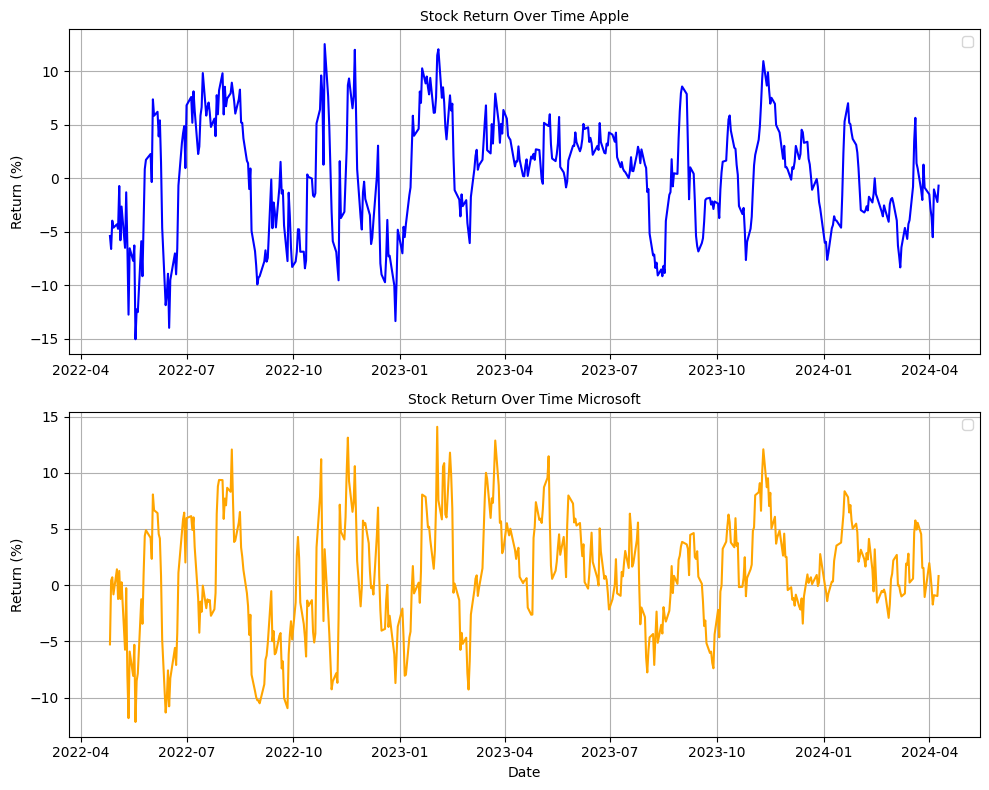

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(data_AAPL.index, data_AAPL["Return 10 in procet"], color='b')
ax1.set_title("Stock Return Over Time Apple", fontsize=10)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel("Return (%)")
ax1.grid(True)
ax1.legend()
ax1.grid(True)


ax2.plot(data_MSFT.index, data_MSFT["Return 10 in procet"], color='orange')
ax2.set_title("Stock Return Over Time Microsoft", fontsize=10)
ax2.tick_params(axis='x', rotation=90)
ax2.set_xlabel("Date")
ax2.set_ylabel("Return (%)")
ax2.grid(True)
ax2.legend()
ax2.grid(True)

ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


I have chosen to estimate from historical data when the distribution of returns is taken from a time series that has already been realized, i.e. it is assumed that returns in the future will be similar to what has already been observed. In this case, the distribution function is based on historical data  and the necessary VaR is calculated based on it.

Only the historical approach to VaR estimation was chosen. Since, parametric approach or monte carlo we will consider only the case when the distribution of returns is normal.

We can consider the following arguments against using the assumption of a normal distribution of returns:

First, the empirical distribution of financial asset returns typically has fat tails than is characteristic of a normal distribution. “Fat tails” is perhaps the most serious problem. This particular case indicates that large losses or gains occur more frequently than is characteristic of a normal distribution. Thus, the probability of exceeding the estimated VaR for a given confidence level alpha is actually higher than (1-alpha).

Secondly, the distribution of financial returns is usually not always symmetric.

While the historical approach is sufficient if we have enough data (e.g., two years of data is typically enough), it only provides a backward-looking view of risk. To improve the accuracy of volatility estimates and account for changing market conditions, I chose to use a GARCH model to estimate volatility, because this model can predict volatility in even in case when variance is not constant. We will assume that the distribution will not change for 10 days, but the variance will fluctuate, and we will forecast 10 days ahead to estimate the variance on the 10th day. In our case, we will estimate the variance of percentage returns. We should take the square root of this variance to find the standard deviation, which will serve as our estimate for Value at Risk.







In [ ]:
confidence_level = 0.95

garch_model_AAPL = arch_model(data_AAPL["Return 10 in procet"].dropna(), vol='Garch', p=1, q=1)
garch_fit_AAPL = garch_model_AAPL.fit(disp='off')

garch_forecast_AAPL = garch_fit_AAPL.forecast(horizon=10)
volatility_AAPL = (garch_forecast_AAPL.variance.iloc[-1, 9] ** 0.5)/100 +1


VaR_historical_AAPL = np.percentile(data_AAPL["Return 10 in procet"].dropna(), (1 - confidence_level) * 100)*volatility_AAPL
print(f"Historical 10-day VaR of AAPL at {confidence_level*100:.0f}% confidence: {VaR_historical_AAPL:.4f}%")

Historical 10-day VaR of AAPL at 95% confidence: -8.8351%


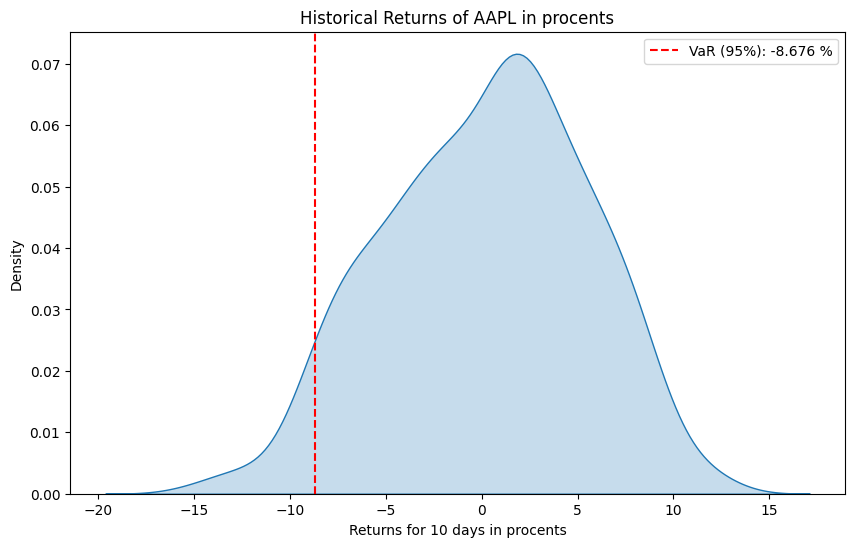

In [ ]:
# visualisation of VaR
def visualize_of_VaR(df, VaR,label:str,k):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df, fill=True)
    plt.axvline(VaR, color='red', linestyle='--', label=f'VaR ({confidence_level*100:.0f}%): {np.round(VaR,3)} %')
    plt.title('Historical Returns of ' + label + ' in procents')
    plt.xlabel('Returns for ' + str(k)+ ' days in procents')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

visualize_of_VaR(data_AAPL["Return 10 in procet"].dropna(),VaR_historical_AAPL,'AAPL', 10)

With a 95 percent probability over the next 10 day, your portfolio that consists only of Apple stock will not lose more than 8.83 percent.  If we were to invest $1 000 000, that would be 81 830 dollars.

In [ ]:
garch_model_MSFT = arch_model(data_MSFT["Return 10 in procet"].dropna(), vol='Garch', p=1, q=1)
garch_fit_MSFT = garch_model_MSFT.fit(disp='off')

garch_forecast_MSFT = garch_fit_MSFT.forecast(horizon=10)
volatility_MSFT = (garch_forecast_MSFT.variance.iloc[-1, 9] ** 0.5)/100 +1

VaR_historical_MSFT = np.percentile(data_MSFT["Return 10 in procet"].dropna(), (1 - confidence_level) * 100)*volatility_MSFT
print(f"Historical 10-day VaR of MSFT at {confidence_level*100:.0f}% confidence: {VaR_historical_MSFT:.4f}%")

Historical 10-day VaR of MSFT at 95% confidence: -8.2822%


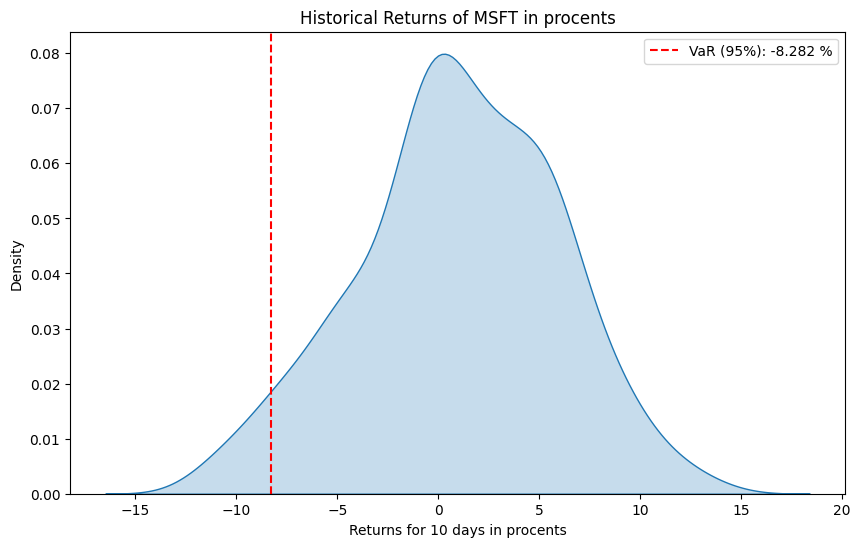

In [ ]:
visualize_of_VaR(data_MSFT["Return 10 in procet"].dropna(),VaR_historical_MSFT,'MSFT', 10)

There is a 5% chance that your portfolio consisting of only Microsoft stock will lose 8.28% or more over the next 10 days. If we were to invest
$1 000 000, that would be 82 822 dollars.

In [ ]:
portfolio = np.array([data_AAPL["Return 10 in procet"],data_MSFT["Return 10 in procet"]])

weights = np.array([0.5,0.5])
portfolio_return = pd.DataFrame(weights@portfolio).dropna()

garch_model_portfolio = arch_model(portfolio_return, vol='Garch', p=1, q=1)
garch_fit_portfolio = garch_model_portfolio.fit(disp='off')

garch_forecast_portfolio = garch_fit_portfolio.forecast(horizon=10)
volatility_portfolio = (garch_forecast_portfolio.variance.iloc[-1, 9] ** 0.5)/100 +1


VaR_historical_portfolio = np.percentile(portfolio_return, (1 - confidence_level) * 100)*volatility_portfolio
print(f"Historical 10-day VaR of portfolio at {confidence_level*100:.0f}% confidence: {VaR_historical_portfolio:.4f}%")

Historical 10-day VaR of portfolio at 95% confidence: -7.5616%


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


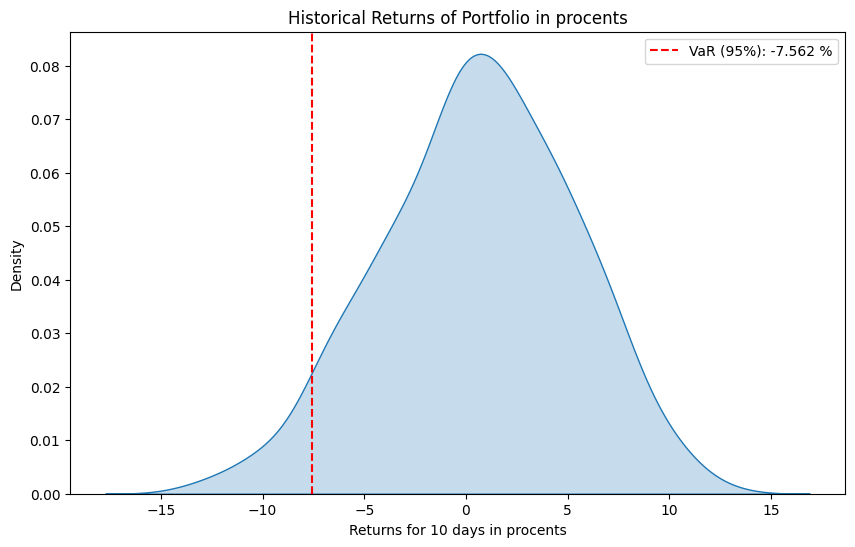

In [ ]:
visualize_of_VaR(portfolio_return,VaR_historical_portfolio,'Portfolio', 10)

Our portfolio consisting of half Apple stock and the other half Microsoft stock has a 95% probability of not declining in value more than 7.562% in 10 days. If we invested $1,000,000 in this portfolio, we would lose 75,616 dollars.
